<a href="https://colab.research.google.com/github/Samjacob007/ADS_Assignment/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries and modules
import os
import random
import io
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    LeakyReLU,
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# OpenCV
import cv2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight, compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)


# Google Colab
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the project path without spaces in the mount point
base_path = '/content/drive/MyDrive/project/brain tumor'

Mounted at /content/drive


In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import Counter
from tqdm import tqdm

# Configuration
base_path = '/content/drive/MyDrive/project/brain tumor'
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 224
sample_size = 500  # Define sample_size to fix the error

# Function to load and sample images
def load_and_sample_images(base_path, subset, sample_size):
    data, labels_list = [], []
    for label_idx, label in enumerate(labels):
        subset_path = os.path.join(base_path, subset, label)
        all_files = os.listdir(subset_path)
        sampled_files = random.sample(all_files, min(len(all_files), sample_size))
        for file in tqdm(sampled_files, desc=f"Processing {subset} - {label}"):
            image = cv2.imread(os.path.join(subset_path, file))
            image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (image_size, image_size))
            data.append(image)
            labels_list.append(label_idx)
    return np.array(data), np.array(labels_list)

# Load Training and Testing Data
x_train, y_train = load_and_sample_images(base_path, 'Training', sample_size)
x_test, y_test = load_and_sample_images(base_path, 'Testing', sample_size)

# Normalize Data and One-Hot Encode Labels
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train, len(labels)), to_categorical(y_test, len(labels))

# Shuffle Data
x_train, y_train = shuffle(x_train, y_train, random_state=42)

# Single Train-Validation Split
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Count Class Distribution
def count_class_distribution(y):
    if len(y.shape) > 1 and y.shape[1] > 1:
        y = np.argmax(y, axis=1)  # Convert one-hot to categorical
    return dict(Counter(y))

# Class Distribution Verification
train_class_counts = count_class_distribution(y_train_final)
val_class_counts = count_class_distribution(y_val)
test_class_counts = count_class_distribution(y_test)

print("Training class distribution:", train_class_counts)
print("Validation class distribution:", val_class_counts)
print("Testing class distribution:", test_class_counts)

# Verify Data Shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")



Processing Testing - pituitary: 100%|██████████| 300/300 [00:03<00:00, 87.08it/s] 


Training class distribution: {0: 394, 1: 409, 2: 393, 3: 404}
Validation class distribution: {3: 96, 1: 91, 0: 106, 2: 107}
Testing class distribution: {0: 300, 1: 306, 2: 405, 3: 300}
x_train shape: (2000, 224, 224, 3)
y_train shape: (2000, 4)
x_test shape: (1311, 224, 224, 3)
y_test shape: (1311, 4)


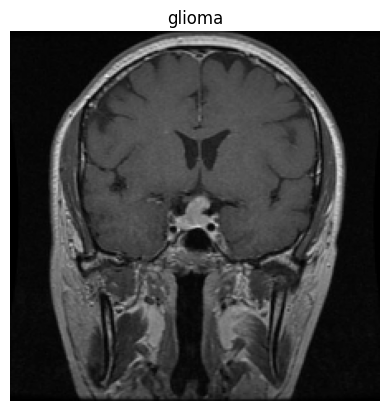

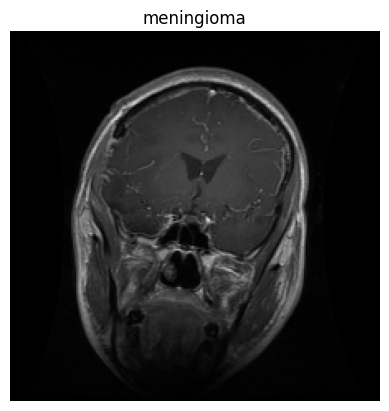

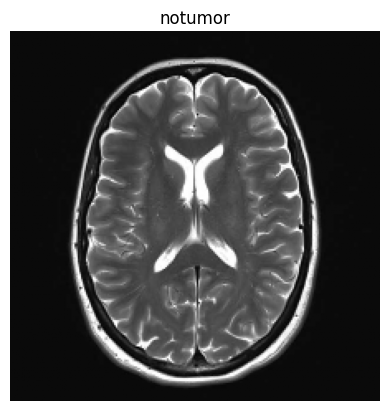

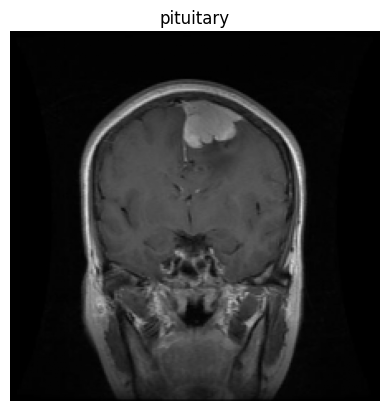

In [5]:
# Display the first image for each class
for i in range(4):
    plt.imshow(x_train[i])
    plt.title(labels[i])
    plt.axis('off')
    plt.show()

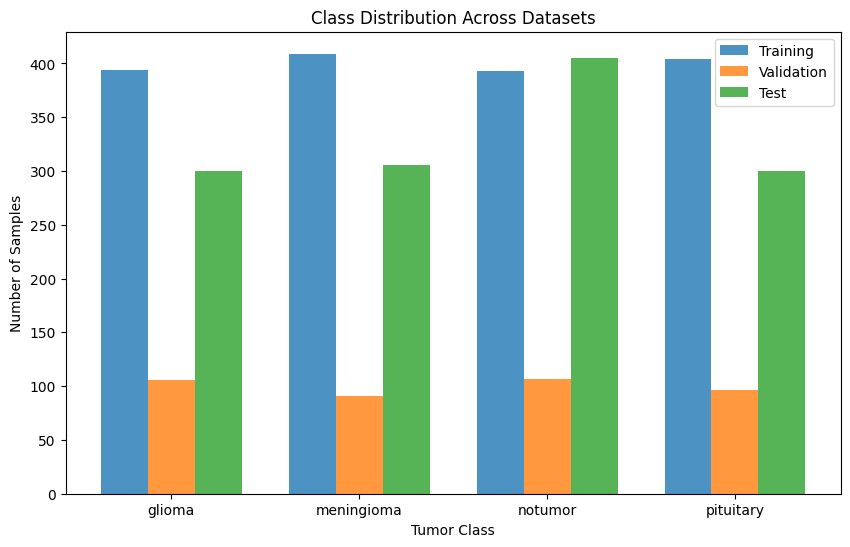

In [6]:
# Sum one-hot encoded labels to get class counts
train_class_counts = np.sum(y_train_final, axis=0)
val_class_counts = np.sum(y_val, axis=0)
test_class_counts = np.sum(y_test, axis=0)  # Replace y_test_classification with y_test

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.25
x_indexes = np.arange(len(class_names))

plt.bar(x_indexes, train_class_counts, width=bar_width, label='Training', alpha=0.8)
plt.bar(x_indexes + bar_width, val_class_counts, width=bar_width, label='Validation', alpha=0.8)
plt.bar(x_indexes + 2 * bar_width, test_class_counts, width=bar_width, label='Test', alpha=0.8)

plt.xticks(x_indexes + bar_width, class_names)
plt.title("Class Distribution Across Datasets")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Samples")
plt.legend()
plt.show()



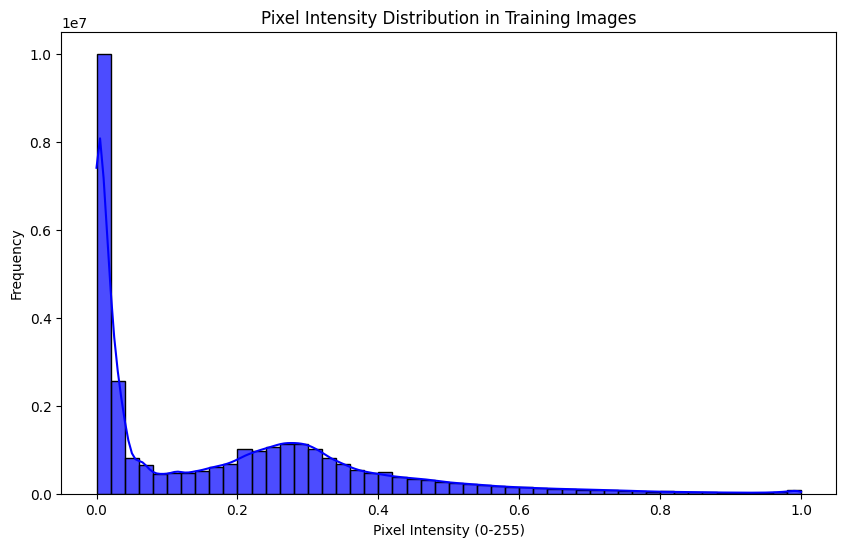

In [7]:


# Flatten pixel values of a random sample from the training set
random_sample = x_train_final[:200]  # Use 200 random images
flattened_pixels = random_sample.reshape(-1)

# Plot histogram of pixel intensities
plt.figure(figsize=(10, 6))
sns.histplot(flattened_pixels, bins=50, kde=True, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution in Training Images")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.show()


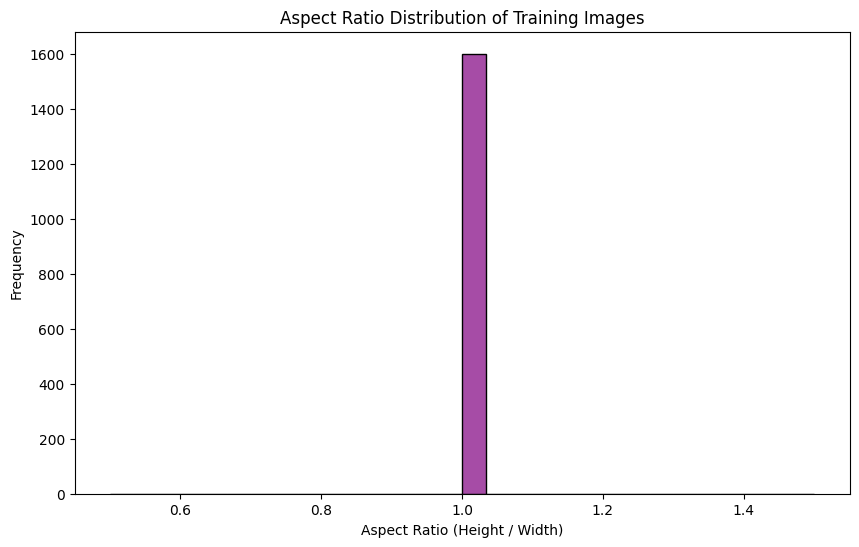

In [8]:
# Extract original image dimensions before resizing
heights = [img.shape[0] for img in x_train_final]
widths = [img.shape[1] for img in x_train_final]

# Calculate aspect ratios
aspect_ratios = np.array(heights) / np.array(widths)

# Plot histogram of aspect ratios
plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=30, kde=True, color='purple', alpha=0.7)
plt.title("Aspect Ratio Distribution of Training Images")
plt.xlabel("Aspect Ratio (Height / Width)")
plt.ylabel("Frequency")
plt.show()

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation on the training set
datagen.fit(x_train_final)

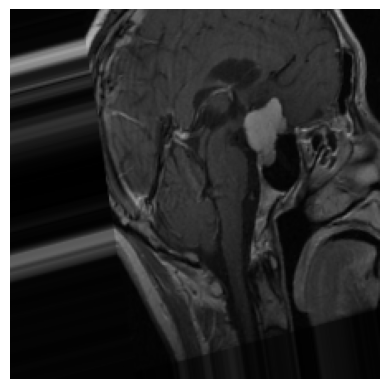

In [10]:
# Visualize Augmented Images
for x_batch, y_batch in datagen.flow(x_train_final, y_train_final, batch_size=4):
    for i in range(4):
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()
    break

In [11]:
# Load Pre-Trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-Tune Last Few Layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add Custom Layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # 4 classes: glioma, meningioma, notumor, pituitary

# Define Model
vgg_model = Model(inputs=base_model.input, outputs=output)

# Compile Model
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Display the Model Summary
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg16_model.keras', monitor='val_loss', save_best_only=True)
]

In [13]:
# Train Model
history_vgg = vgg_model.fit(
    datagen.flow(x_train_final, y_train_final, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
50/50 [==============================] - 111s 2s/step - loss: 5.0764 - accuracy: 0.3881 - precision: 0.5749 - recall: 0.1488 - val_loss: 3.5132 - val_accuracy: 0.6825 - val_precision: 0.7981 - val_recall: 0.4150 - lr: 1.0000e-04
Epoch 2/30
50/50 [==============================] - 108s 2s/step - loss: 2.9013 - accuracy: 0.6288 - precision: 0.7378 - recall: 0.4837 - val_loss: 2.0685 - val_accuracy: 0.7550 - val_precision: 0.8436 - val_recall: 0.6875 - lr: 1.0000e-04
Epoch 3/30
50/50 [==============================] - 107s 2s/step - loss: 1.9323 - accuracy: 0.6894 - precision: 0.7652 - recall: 0.6050 - val_loss: 1.6786 - val_accuracy: 0.7550 - val_precision: 0.7836 - val_recall: 0.7150 - lr: 1.0000e-04
Epoch 4/30
50/50 [==============================] - 107s 2s/step - loss: 1.4277 - accuracy: 0.7519 - precision: 0.7968 - recall: 0.6913 - val_loss: 1.1623 - val_accuracy: 0.8200 - val_precision: 0.8351 - val_recall: 0.7975 - lr: 1.0000e-04
Epoch 5/30
50/50 [======================

In [15]:
# Evaluate Model
test_loss, test_accuracy, test_precision, test_recall = vgg_model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


41/41 [==============================] - 24s 586ms/step - loss: 0.3922 - accuracy: 0.9298 - precision: 0.9361 - recall: 0.9275
Test Loss: 0.3921952545642853
Test Accuracy: 0.9298245906829834
Test Precision: 0.9361047148704529
Test Recall: 0.9275362491607666


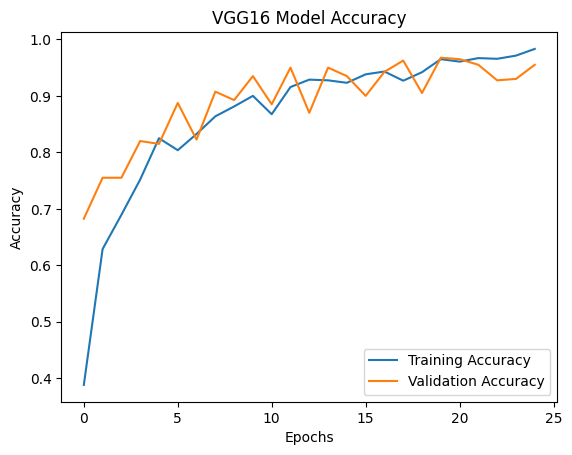

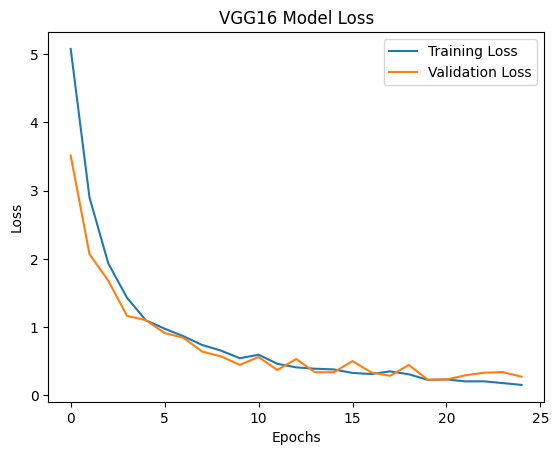

In [16]:
# Plot training and validation accuracy
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title("VGG16 Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title("VGG16 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

50/50 [==============================] - 29s 574ms/step


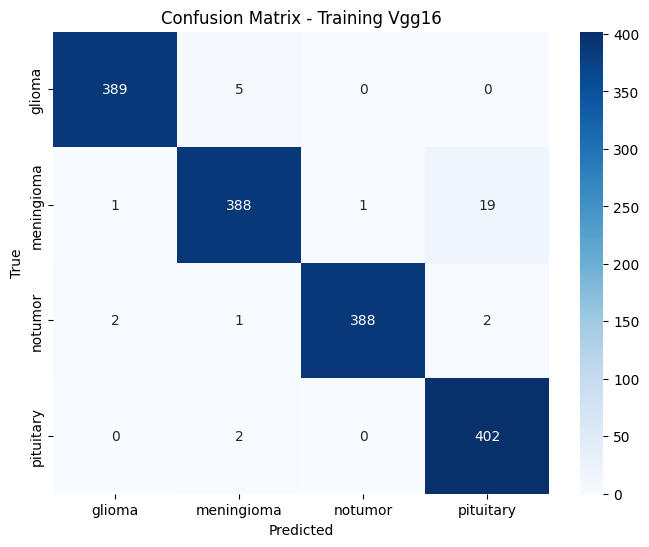

In [98]:
# Get predictions for the training set
y_pred_train = np.argmax(vgg_model.predict(x_train_final), axis=1)
y_true_train = np.argmax(y_train_final, axis=1)

# Generate the confusion matrix
cm_train = confusion_matrix(y_true_train, y_pred_train)

# Plot confusion matrix for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Vgg16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

41/41 [==============================] - 25s 599ms/step

Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.89      0.92       300
  meningioma       0.88      0.90      0.89       306
     notumor       0.97      0.94      0.96       405
   pituitary       0.90      0.99      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



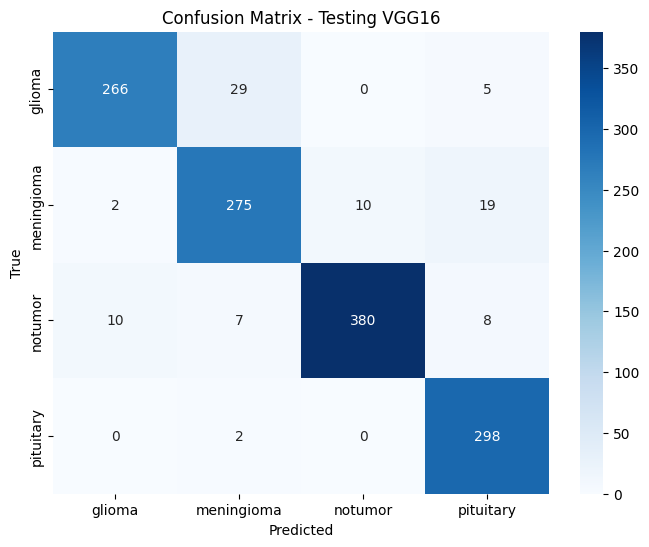

In [97]:
# Predictions
y_pred_vgg = np.argmax(vgg_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)  # Replace y_test_classification with y_test

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_vgg, target_names=labels))

# Confusion matrix
cm_vgg = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Testing VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


41/41 [==============================] - 25s 603ms/step


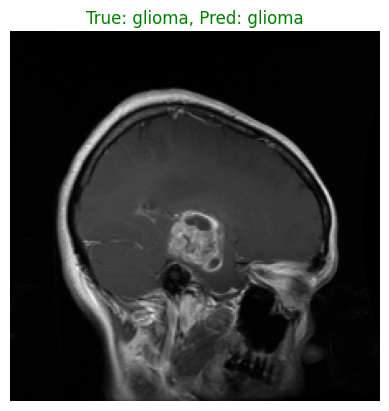

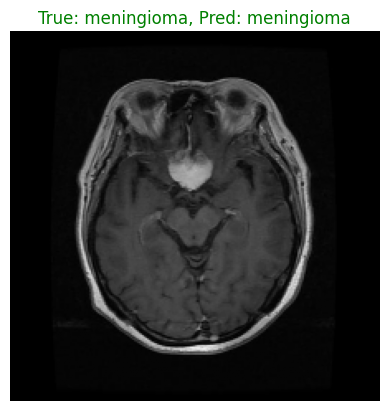

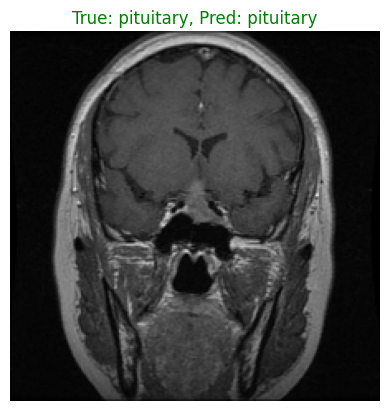

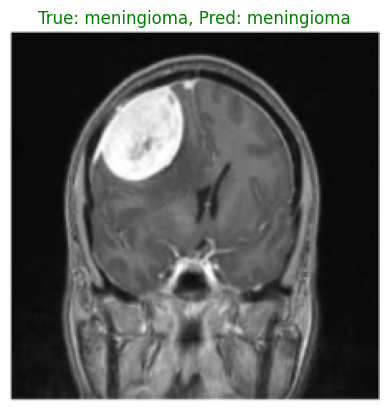

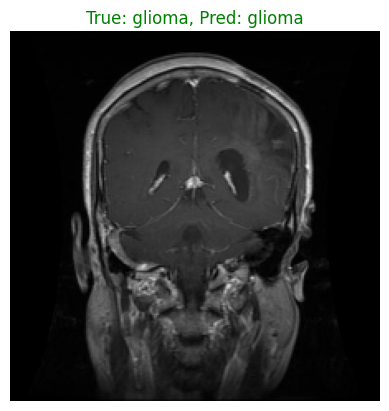

In [21]:
# Predictions
y_pred = np.argmax(vgg_model.predict(x_test), axis=1)  # Get class indices for predictions

# Display 5 random images with predictions
for i in range(5):  # Display 5 random images
    idx = random.randint(0, len(x_test) - 1)  # Select a random index
    plt.imshow(x_test[idx])  # Display the corresponding image
    true_label = labels[np.argmax(y_test[idx])]  # Replace y_test_classification with y_test
    predicted_label = labels[y_pred[idx]]  # Predicted label
    color = 'green' if true_label == predicted_label else 'red'  # Highlight correct/incorrect
    plt.title(f"True: {true_label}, Pred: {predicted_label}", color=color)
    plt.axis('off')  # Hide axes
    plt.show()  # Display the image


In [22]:


# Define the dataset path and classes
base_path = '/content/drive/MyDrive/project/brain tumor'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_folders = ['Training', 'Testing']  # Choose whether to use Training or Testing images

# Function to fetch random images from each class
def fetch_images(base_path, data_folder, class_labels, num_samples=3):
    images_by_class = {}
    for label in class_labels:
        folder_path = os.path.join(base_path, data_folder, label)
        all_files = os.listdir(folder_path)
        sampled_files = random.sample(all_files, min(len(all_files), num_samples))  # Randomly sample
        images_by_class[label] = [os.path.join(folder_path, f) for f in sampled_files]
    return images_by_class

# Fetch images dynamically
sample_image_paths = fetch_images(base_path, 'Testing', class_labels)

# Print selected images for verification
for label, paths in sample_image_paths.items():
    print(f"Class: {label}")
    for path in paths:
        print(f"  {path}")

Class: glioma
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0204.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0218.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0120.jpg
Class: meningioma
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0206.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0152.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0113.jpg
Class: notumor
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0079.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0313.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0299.jpg
Class: pituitary
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0184.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0180.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-piTr_0003.jpg


In [23]:


def visualize_gradcam(img_path, model, layer_name, class_labels):
    """
    Generate and display Grad-CAM heatmaps for an input image.
    """
    from tensorflow.keras.models import Model
    import tensorflow as tf

    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Create a model that outputs the activations of the target layer
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Get the class index with the highest predicted probability
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])

    # Compute the gradient of the predicted class with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]

    # Compute the Grad-CAM heatmap
    weights = np.mean(guided_grads, axis=(0, 1))
    heatmap = np.dot(conv_outputs, weights)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match Grad-CAM heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM - Predicted: {class_labels[pred_class_idx]}")
    plt.axis('off')
    plt.show()


Generating Grad-CAM for class: glioma

1/1 [==============================] - 0s 71ms/step


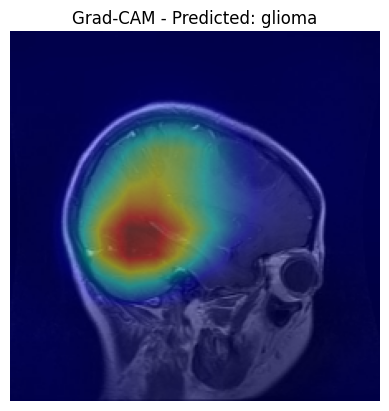

1/1 [==============================] - 0s 71ms/step


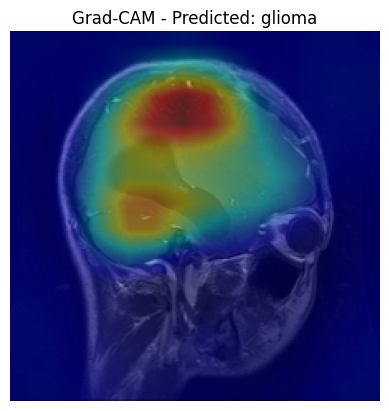

1/1 [==============================] - 0s 72ms/step


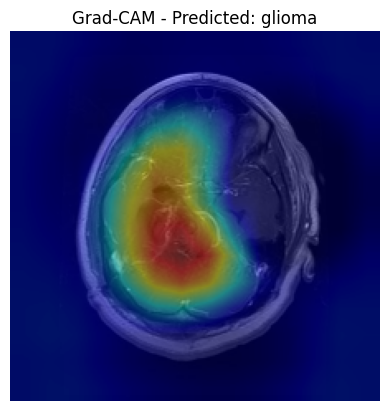


Generating Grad-CAM for class: meningioma

1/1 [==============================] - 0s 72ms/step


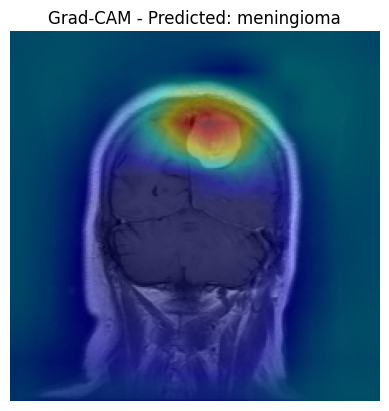

1/1 [==============================] - 0s 70ms/step


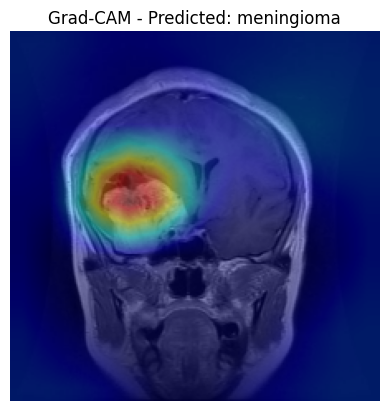

1/1 [==============================] - 0s 72ms/step


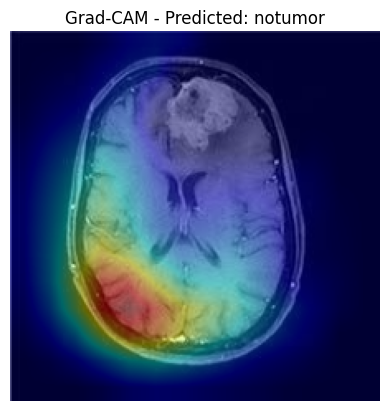


Generating Grad-CAM for class: notumor

1/1 [==============================] - 0s 72ms/step


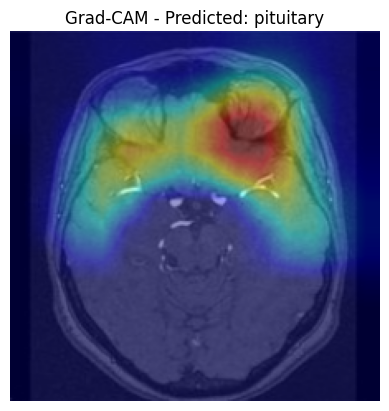

1/1 [==============================] - 0s 75ms/step


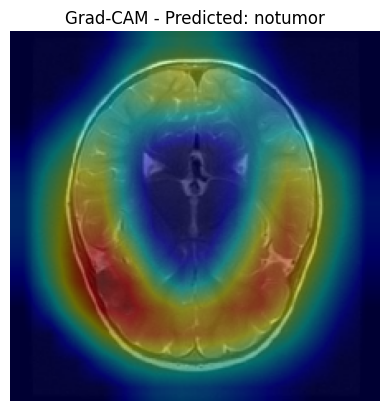

1/1 [==============================] - 0s 77ms/step


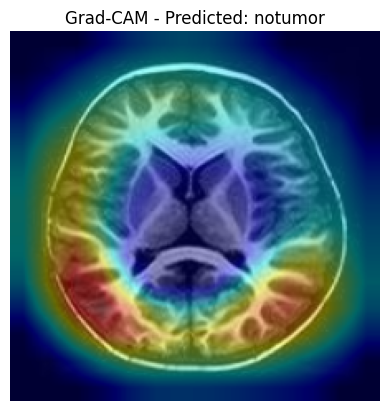


Generating Grad-CAM for class: pituitary

1/1 [==============================] - 0s 73ms/step


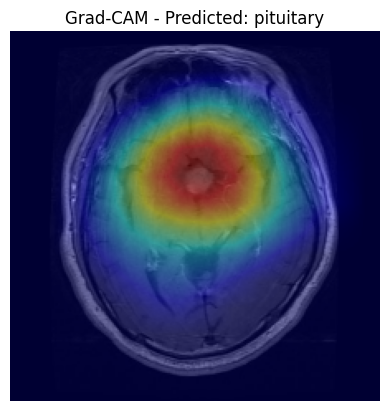

1/1 [==============================] - 0s 74ms/step


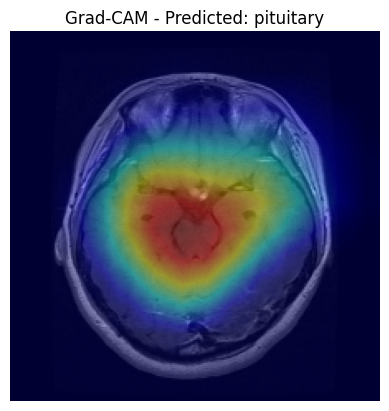

1/1 [==============================] - 0s 73ms/step


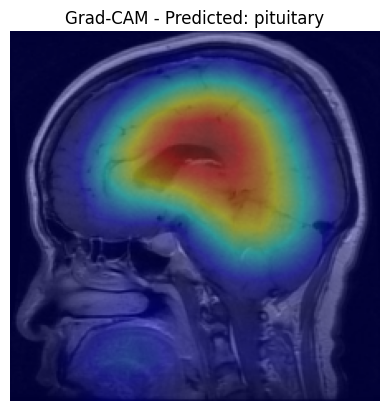

In [28]:
for label, paths in sample_image_paths.items():
    print(f"\nGenerating Grad-CAM for class: {label}\n")
    for img_path in paths:
        visualize_gradcam(img_path, vgg_model, layer_name='block5_conv3', class_labels=class_labels)

In [29]:
# Save the model
vgg_model.save('vgg16_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('vgg16_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train_final)

In [31]:
# Load Pretrained ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-Tuning: Unfreeze the Last 50 Layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Custom Top Layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)  # Adjusted Dropout
output = Dense(4, activation='softmax')(x)  # 4 classes: glioma, meningioma, notumor, pituitary

# Define Model
resnet_model = Model(inputs=base_model.input, outputs=output)

# Compile Model
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
resnet_model.summary()



94765736/94765736 [==============================] - 0s 0us/step
Model: "model_61"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [32]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint('best_resnet50_model.h5', monitor='val_loss', save_best_only=True)
]

In [33]:
# Updated epochs with early stopping
history_resnet = resnet_model.fit(
    datagen.flow(x_train_final, y_train_final, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=30,  # Start with 30 epochs
    callbacks=callbacks
)


Epoch 1/30
50/50 [==============================] - 62s 1s/step - loss: 5.9639 - accuracy: 0.6081 - precision_1: 0.6578 - recall_1: 0.5394 - val_loss: 6.5098 - val_accuracy: 0.2575 - val_precision_1: 0.2417 - val_recall_1: 0.2000 - lr: 1.0000e-05
Epoch 2/30
50/50 [==============================] - 54s 1s/step - loss: 5.6214 - accuracy: 0.6837 - precision_1: 0.7129 - recall_1: 0.6300 - val_loss: 6.1990 - val_accuracy: 0.2525 - val_precision_1: 0.4103 - val_recall_1: 0.1600 - lr: 1.0000e-05
Epoch 3/30
50/50 [==============================] - 54s 1s/step - loss: 5.4092 - accuracy: 0.7019 - precision_1: 0.7493 - recall_1: 0.6444 - val_loss: 5.8654 - val_accuracy: 0.4000 - val_precision_1: 0.5118 - val_recall_1: 0.3250 - lr: 1.0000e-05
Epoch 4/30
50/50 [==============================] - 54s 1s/step - loss: 5.2534 - accuracy: 0.7138 - precision_1: 0.7512 - recall_1: 0.6719 - val_loss: 5.4183 - val_accuracy: 0.5525 - val_precision_1: 0.6895 - val_recall_1: 0.4275 - lr: 1.0000e-05
Epoch 5/30
5

In [35]:
# Evaluate the model
results = resnet_model.evaluate(x_test, y_test)
test_loss, test_accuracy, test_precision, test_recall = results

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")



41/41 [==============================] - 22s 528ms/step - loss: 3.2107 - accuracy: 0.7857 - precision_1: 0.7972 - recall_1: 0.7704
Test Loss: 3.2107129096984863
Test Accuracy: 0.7856597900390625
Test Precision: 0.7971586585044861
Test Recall: 0.7704042792320251


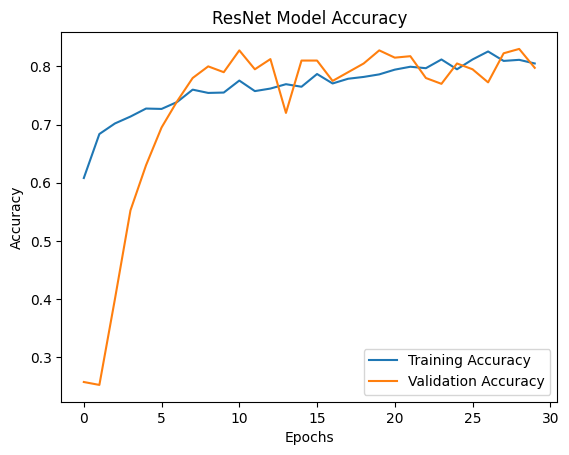

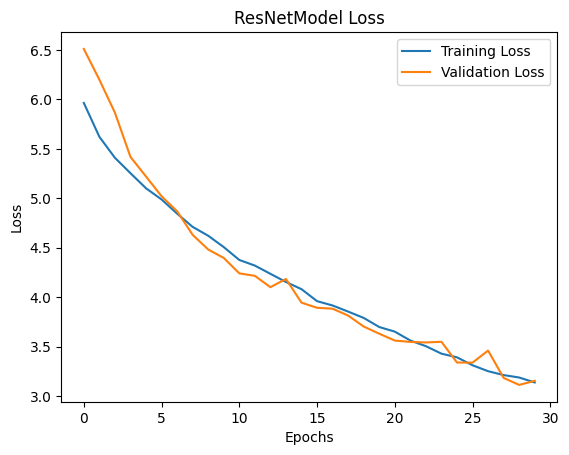

In [36]:
# Plot training and validation accuracy for ResNet50
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title("ResNet Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss for ResNet50
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title("ResNetModel Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


50/50 [==============================] - 26s 521ms/step


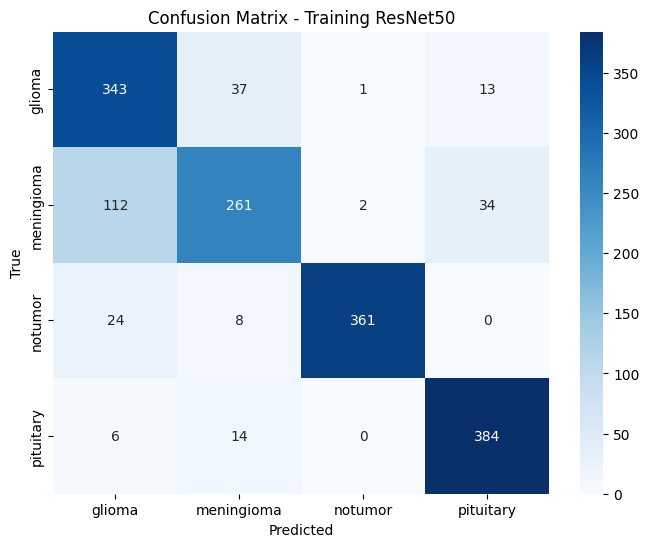

In [99]:
# Get predictions for the training set
y_pred_train_resnet = np.argmax(resnet_model.predict(x_train_final), axis=1)
y_true_train_resnet = np.argmax(y_train_final, axis=1)

# Generate the confusion matrix for ResNet50
cm_train_resnet = confusion_matrix(y_true_train_resnet, y_pred_train_resnet)

# Plot confusion matrix for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


41/41 [==============================] - 22s 531ms/step

Classification Report - ResNet50:
               precision    recall  f1-score   support

      glioma       0.68      0.76      0.72       300
  meningioma       0.70      0.55      0.61       306
     notumor       0.89      0.88      0.89       405
   pituitary       0.82      0.93      0.87       300

    accuracy                           0.79      1311
   macro avg       0.77      0.78      0.77      1311
weighted avg       0.78      0.79      0.78      1311



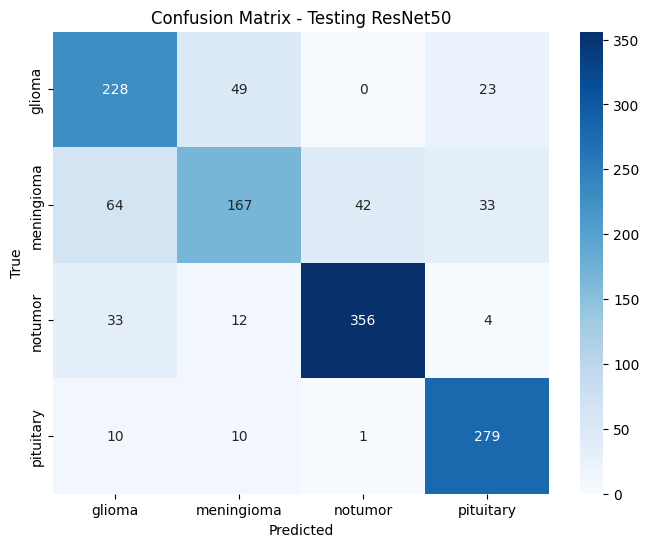

In [100]:
# Predictions for ResNet50
y_pred_resnet = np.argmax(resnet_model.predict(x_test), axis=1)
y_true_resnet = np.argmax(y_test, axis=1)  # Replace y_test_classification with y_test

# Classification report for ResNet50
print("\nClassification Report - ResNet50:\n", classification_report(y_true_resnet, y_pred_resnet, target_names=labels))

# Confusion matrix for ResNet50
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Testing ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


41/41 [==============================] - 22s 537ms/step


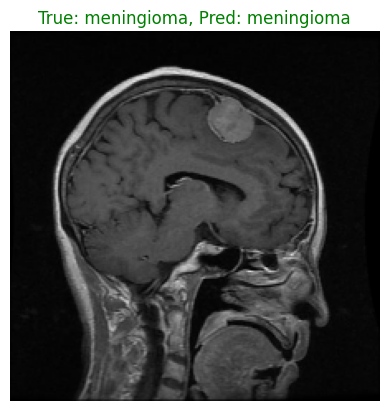

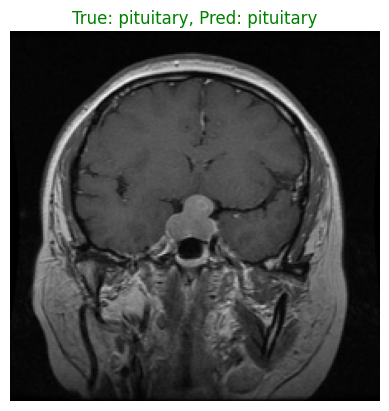

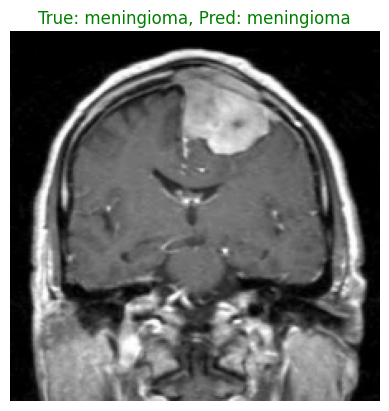

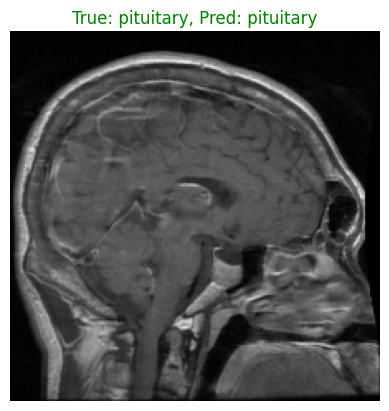

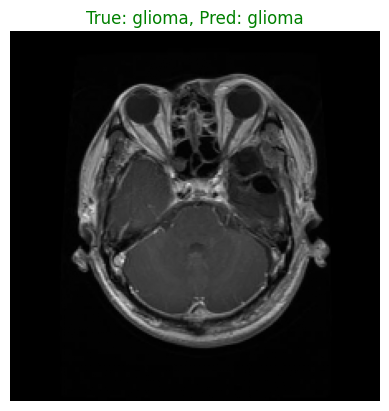

In [42]:
# Get predictions for the test set
resnet_predictions = np.argmax(resnet_model.predict(x_test), axis=1)  # Predictions for x_test

# Display 5 random images with true and predicted labels
for i in range(5):
    idx = random.randint(0, len(x_test) - 1)  # Select a random index
    plt.imshow(x_test[idx])  # Display the image

    # Correct the true label reference
    true_label = labels[np.argmax(y_test[idx])]  # Replace y_test_classification with y_test

    predicted_label = labels[resnet_predictions[idx]]  # Predicted label
    color = 'green' if true_label == predicted_label else 'red'  # Correct = green, Incorrect = red

    plt.title(f"True: {true_label}, Pred: {predicted_label}", color=color)
    plt.axis('off')  # Hide axes
    plt.show()  # Display the image



Class: glioma
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0267.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0298.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0149.jpg
Class: meningioma
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0172.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-meTr_0002.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0282.jpg
Class: notumor
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0202.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0370.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0109.jpg
Class: pituitary
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0214.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0185.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0249.jpg

Generatin

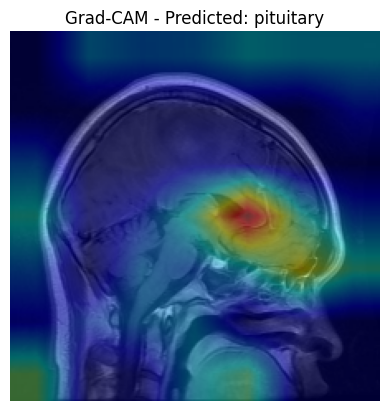

1/1 [==============================] - 0s 93ms/step


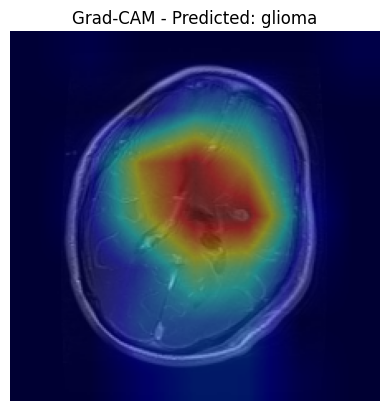

1/1 [==============================] - 0s 94ms/step


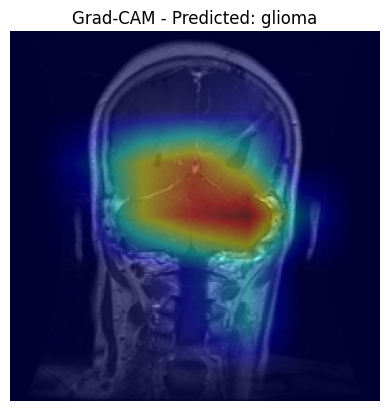


Generating Grad-CAM for class: meningioma

1/1 [==============================] - 0s 96ms/step


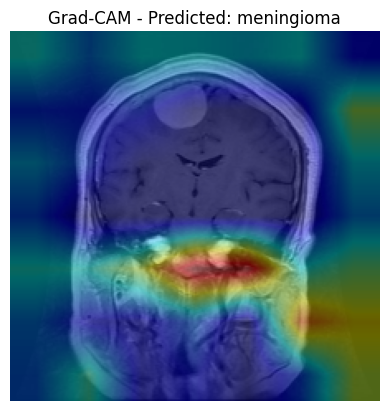

1/1 [==============================] - 0s 94ms/step


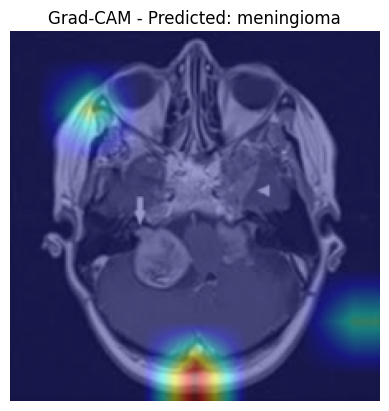

1/1 [==============================] - 0s 92ms/step


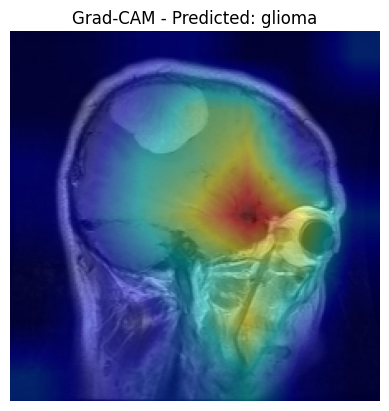


Generating Grad-CAM for class: notumor

1/1 [==============================] - 0s 99ms/step


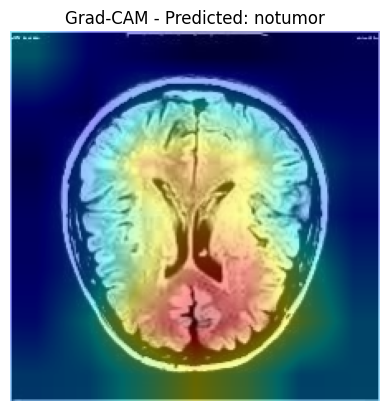

1/1 [==============================] - 0s 97ms/step


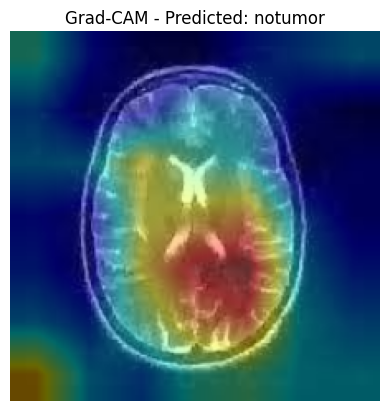

1/1 [==============================] - 0s 93ms/step


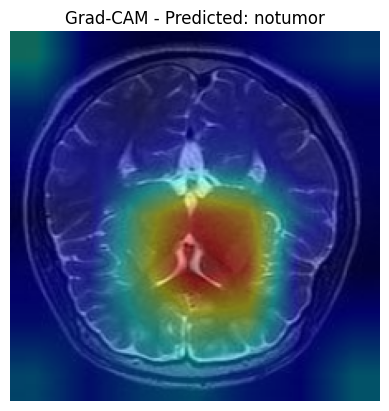


Generating Grad-CAM for class: pituitary

1/1 [==============================] - 0s 100ms/step


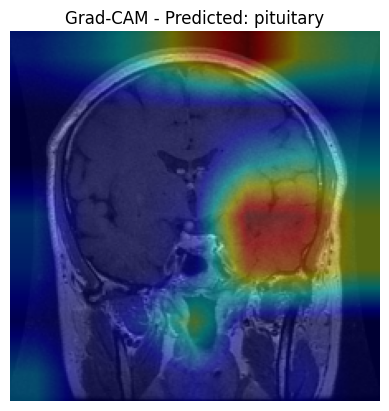

1/1 [==============================] - 0s 95ms/step


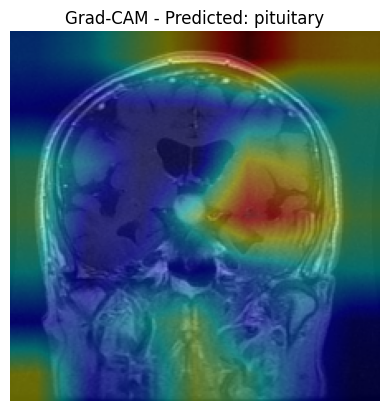

1/1 [==============================] - 0s 92ms/step


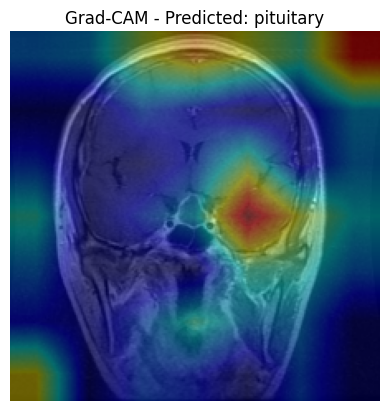

In [44]:
# Define the dataset path and classes
base_path = '/content/drive/MyDrive/project/brain tumor'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_folders = ['Training', 'Testing']  # Choose whether to use Training or Testing images

# Function to fetch random images from each class
def fetch_images(base_path, data_folder, class_labels, num_samples=3):
    images_by_class = {}
    for label in class_labels:
        folder_path = os.path.join(base_path, data_folder, label)
        all_files = os.listdir(folder_path)
        sampled_files = random.sample(all_files, min(len(all_files), num_samples))  # Randomly sample
        images_by_class[label] = [os.path.join(folder_path, f) for f in sampled_files]
    return images_by_class

# Fetch images dynamically
sample_image_paths = fetch_images(base_path, 'Testing', class_labels)

# Print selected images for verification
for label, paths in sample_image_paths.items():
    print(f"Class: {label}")
    for path in paths:
        print(f"  {path}")


def visualize_gradcam_resnet(img_path, model, layer_name, class_labels):
    """
    Generate and display Grad-CAM heatmaps for an input image for ResNet50.
    """


    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Create a model that outputs the activations of the target layer
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Get the class index with the highest predicted probability
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])

    # Compute the gradient of the predicted class with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]

    # Compute the Grad-CAM heatmap
    weights = np.mean(guided_grads, axis=(0, 1))
    heatmap = np.dot(conv_outputs, weights)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match Grad-CAM heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM - Predicted: {class_labels[pred_class_idx]}")
    plt.axis('off')
    plt.show()

# Specify the last convolutional layer in ResNet50
layer_name = 'conv5_block3_out'  # Adjust based on your ResNet50 architecture

# Generate Grad-CAM for each class
for label, paths in sample_image_paths.items():
    print(f"\nGenerating Grad-CAM for class: {label}\n")
    for img_path in paths:
        visualize_gradcam_resnet(img_path, resnet_model, layer_name, class_labels=class_labels)


In [45]:
# Save the model
resnet_model.save('resnet_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('resnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Reduced for smoother augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,  # Vertical flips removed (not relevant for medical images)
    fill_mode='nearest'
)
datagen.fit(x_train)

In [47]:
# Define the Model Architecture
def create_custom_cnn(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization added
    model.add(Dropout(0.5))  # Stronger regularization to avoid overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Final classification layer

    return model

# Define the model
input_shape = (224, 224, 3)  # Input size
num_classes = 4  # Number of tumor classes
custom_cnn = create_custom_cnn(input_shape, num_classes)

# Learning Rate Scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,  # Slightly lower starting LR
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

# Compile the Model
custom_cnn.compile(
    optimizer=Adam(learning_rate=lr_schedule),  # Switched to Adam for better optimization
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# Display the Model Summary
custom_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_2 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                        

In [48]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),  # Allow more patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint('best_custom_cnn.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

In [50]:
# Train the Model
history_custom_cnn = custom_cnn.fit(
    datagen.flow(x_train, y_train, batch_size=32),  # Replace y_train_classification with y_train
    validation_data=(x_val, y_val),
    epochs=50,  # Allow up to 50 epochs for better convergence
    callbacks=callbacks
)


Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 6.6027 - accuracy: 0.5060 - precision: 0.5400 - recall: 0.4450
Epoch 1: val_loss improved from inf to 11.86051, saving model to best_custom_cnn.h5
63/63 [==============================] - 49s 750ms/step - loss: 6.6027 - accuracy: 0.5060 - precision: 0.5400 - recall: 0.4450 - val_loss: 11.8605 - val_accuracy: 0.2650 - val_precision: 0.2650 - val_recall: 0.2650 - lr: 1.0000e-04
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 5.8163 - accuracy: 0.5685 - precision: 0.6483 - recall: 0.4360
Epoch 2: val_loss did not improve from 11.86051
63/63 [==============================] - 46s 720ms/step - loss: 5.8163 - accuracy: 0.5685 - precision: 0.6483 - recall: 0.4360 - val_loss: 15.1204 - val_accuracy: 0.2650 - val_precision: 0.2650 - val_recall: 0.2650 - lr: 1.0000e-04
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 5.3939 - accuracy: 0.6130 - precision: 0.7101 - recall: 0.4690
Epoch 3: va

In [52]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = custom_cnn.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


41/41 [==============================] - 6s 150ms/step - loss: 0.8292 - accuracy: 0.8474 - precision: 0.8592 - recall: 0.8238
Test Loss: 0.8291832208633423
Test Accuracy: 0.8474447131156921
Test Precision: 0.8591885566711426
Test Recall: 0.823798656463623


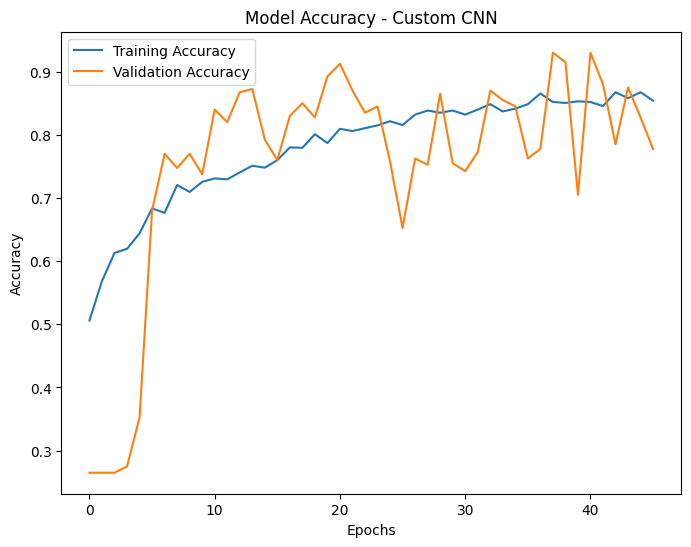

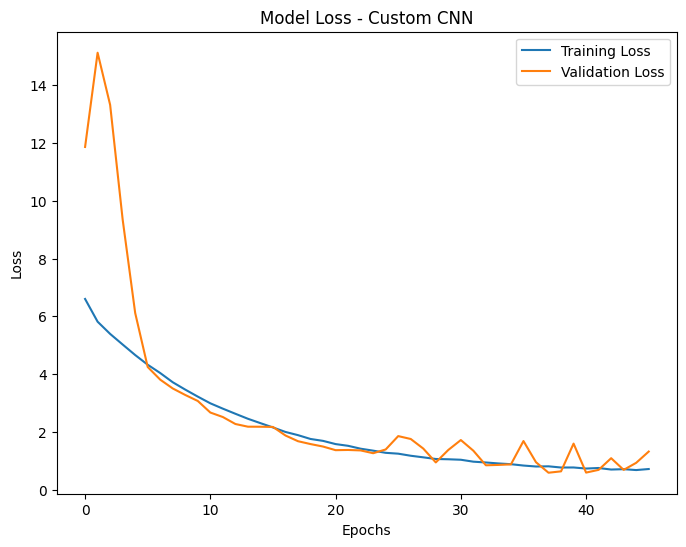

In [53]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_custom_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_custom_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy - Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history_custom_cnn.history['loss'], label='Training Loss')
plt.plot(history_custom_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

50/50 [==============================] - 8s 153ms/step


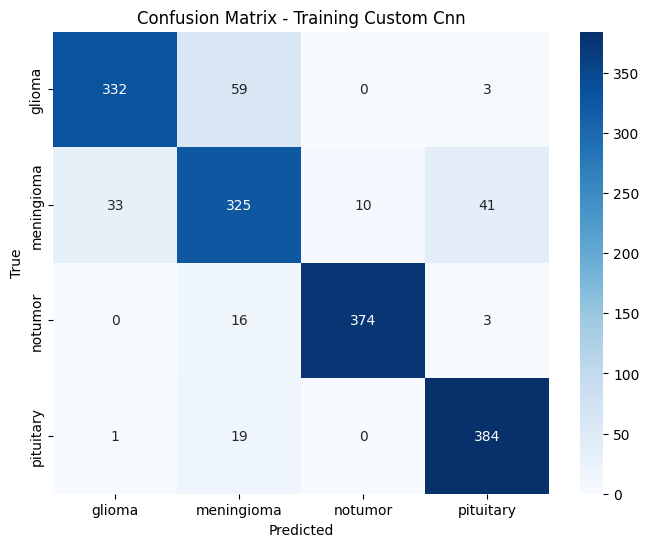

In [101]:
# Get predictions for the training set
y_train_pred = custom_cnn.predict(x_train_final)
y_train_pred_classes = y_train_pred.argmax(axis=1)
y_train_true_classes = y_train_final.argmax(axis=1)

# Generate the confusion matrix
cm_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Custom Cnn")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

41/41 [==============================] - 6s 157ms/step
              precision    recall  f1-score   support

      glioma       0.90      0.78      0.84       300
  meningioma       0.72      0.71      0.71       306
    no tumor       0.90      0.92      0.91       405
   pituitary       0.86      0.96      0.91       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



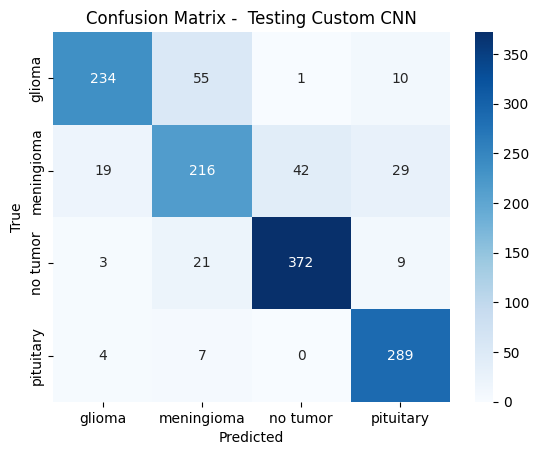

In [102]:

# Predictions
y_pred_test = np.argmax(custom_cnn.predict(x_test), axis=1)
y_true_test = np.argmax(y_test, axis=1)  # Replace y_test_classification with y_test

print(classification_report(y_true_test, y_pred_test, target_names=['glioma', 'meningioma', 'no tumor', 'pituitary']))

# Confusion Matrix
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])
plt.title('Confusion Matrix -  Testing Custom CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Class: glioma
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0220.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0176.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0018.jpg
Class: meningioma
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0012.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0049.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0035.jpg
Class: notumor
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0174.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0079.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0400.jpg
Class: pituitary
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0187.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0037.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0014.jpg

Generating 

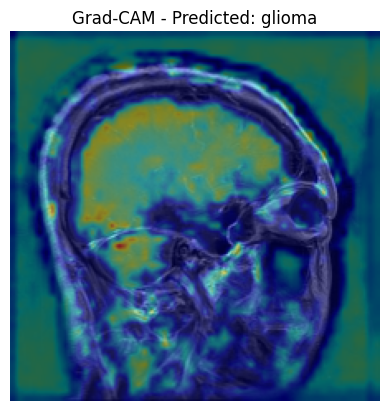

1/1 [==============================] - 0s 42ms/step


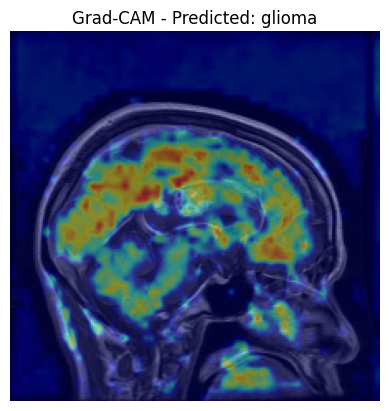

1/1 [==============================] - 0s 44ms/step


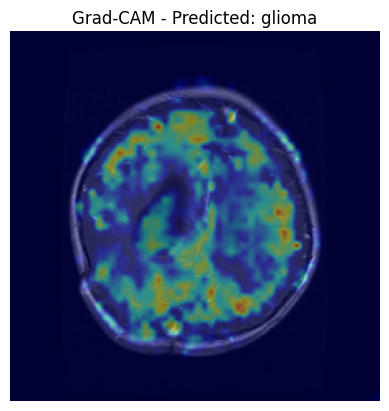


Generating Grad-CAM for class: meningioma

1/1 [==============================] - 0s 46ms/step


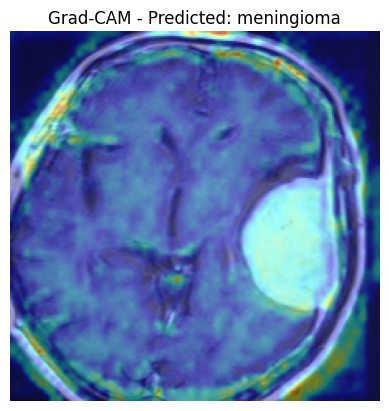

1/1 [==============================] - 0s 45ms/step


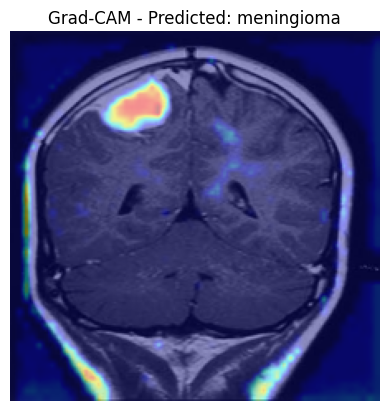

1/1 [==============================] - 0s 44ms/step


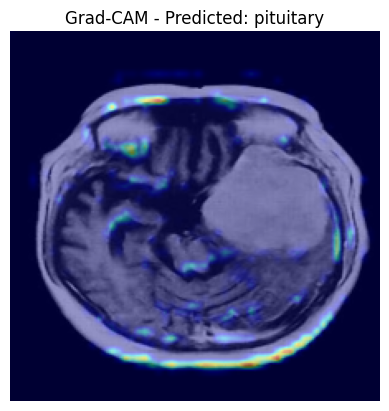


Generating Grad-CAM for class: notumor

1/1 [==============================] - 0s 40ms/step


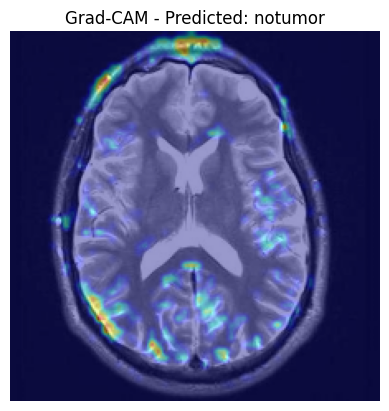

1/1 [==============================] - 0s 46ms/step


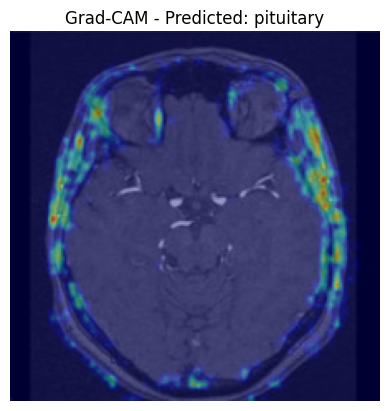

1/1 [==============================] - 0s 42ms/step


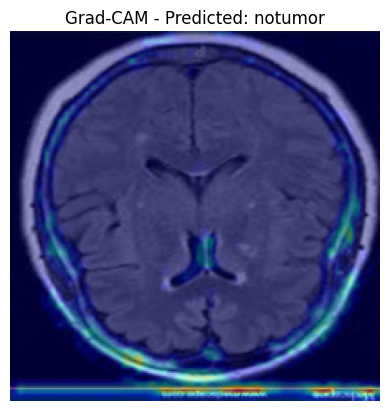


Generating Grad-CAM for class: pituitary

1/1 [==============================] - 0s 45ms/step


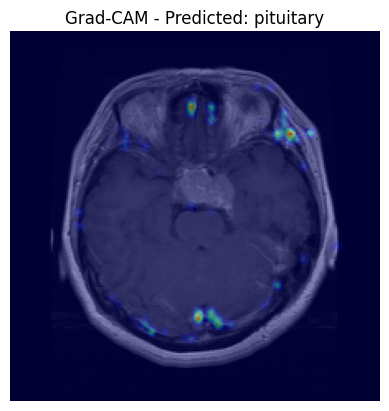

1/1 [==============================] - 0s 46ms/step


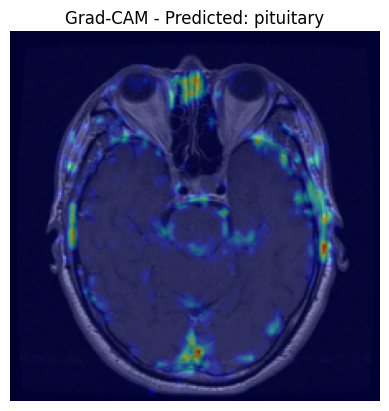

1/1 [==============================] - 0s 46ms/step


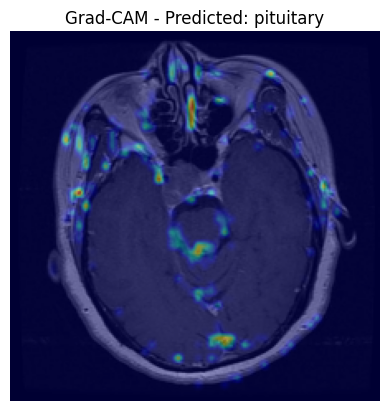

In [58]:
# Define the dataset path and classes
base_path = '/content/drive/MyDrive/project/brain tumor'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_folders = ['Training', 'Testing']  # Choose whether to use Training or Testing images

# Function to fetch random images from each class
def fetch_images(base_path, data_folder, class_labels, num_samples=3):
    images_by_class = {}
    for label in class_labels:
        folder_path = os.path.join(base_path, data_folder, label)
        all_files = os.listdir(folder_path)
        sampled_files = random.sample(all_files, min(len(all_files), num_samples))  # Randomly sample
        images_by_class[label] = [os.path.join(folder_path, f) for f in sampled_files]
    return images_by_class

# Fetch images dynamically
sample_image_paths = fetch_images(base_path, 'Testing', class_labels)

# Print selected images for verification
for label, paths in sample_image_paths.items():
    print(f"Class: {label}")
    for path in paths:
        print(f"  {path}")

# Grad-CAM function for Custom CNN
def visualize_gradcam_custom(img_path, model, layer_name, class_labels):
    """
    Generate and display Grad-CAM heatmaps for an input image for Custom CNN.
    """
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Create a model that outputs the activations of the target layer
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Get the class index with the highest predicted probability
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])

    # Compute the gradient of the predicted class with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]

    # Compute the Grad-CAM heatmap
    weights = np.mean(guided_grads, axis=(0, 1))
    heatmap = np.dot(conv_outputs, weights)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match Grad-CAM heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM - Predicted: {class_labels[pred_class_idx]}")
    plt.axis('off')
    plt.show()

# Specify the last convolutional layer in your custom CNN
# Use model.summary() to identify the correct layer
layer_name = 'conv2d_2'  # Adjust this to the last convolutional layer in your custom CNN

# Generate Grad-CAM for each class
for label, paths in sample_image_paths.items():
    print(f"\nGenerating Grad-CAM for class: {label}\n")
    for img_path in paths:
        visualize_gradcam_custom(img_path, custom_cnn, layer_name, class_labels=class_labels)


In [59]:
# Save the model
custom_cnn.save('custom_cnn_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('custom_cnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [104]:
# Set model weights for weighted voting (VGG16 has the highest weight)
weights = [0.5, 0.3, 0.2]  # Adjust weights based on performance of each model

# Get predicted probabilities for each model
vgg_probs = vgg_model.predict(x_test)
resnet_probs = resnet_model.predict(x_test)
custom_probs = custom_cnn.predict(x_test)

# Weighted average of probabilities
ensemble_probs = (vgg_probs * weights[0]) + (resnet_probs * weights[1]) + (custom_probs * weights[2])

# Get the final predictions by selecting the class with the highest probability
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# Evaluate Performance
y_true = np.argmax(y_test, axis=1)  # Convert one-hot to categorical

accuracy = accuracy_score(y_true, ensemble_preds)
precision = precision_score(y_true, ensemble_preds, average='weighted')
recall = recall_score(y_true, ensemble_preds, average='weighted')
f1 = f1_score(y_true, ensemble_preds, average='weighted')

print(f"Weighted Voting Accuracy: {accuracy}")
print(f"Weighted Voting Precision: {precision}")
print(f"Weighted Voting Recall: {recall}")
print(f"Weighted Voting F1-Score: {f1}")






41/41 [==============================] - 6s 149ms/step
Weighted Voting Accuracy: 0.9328756674294432
Weighted Voting Precision: 0.9333896734380672
Weighted Voting Recall: 0.9328756674294432
Weighted Voting F1-Score: 0.9325919214093532



Classification Report (Weighted Voting):

              precision    recall  f1-score   support

      glioma       0.96      0.90      0.93       300
  meningioma       0.89      0.88      0.88       306
     notumor       0.95      0.96      0.95       405
   pituitary       0.92      0.99      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



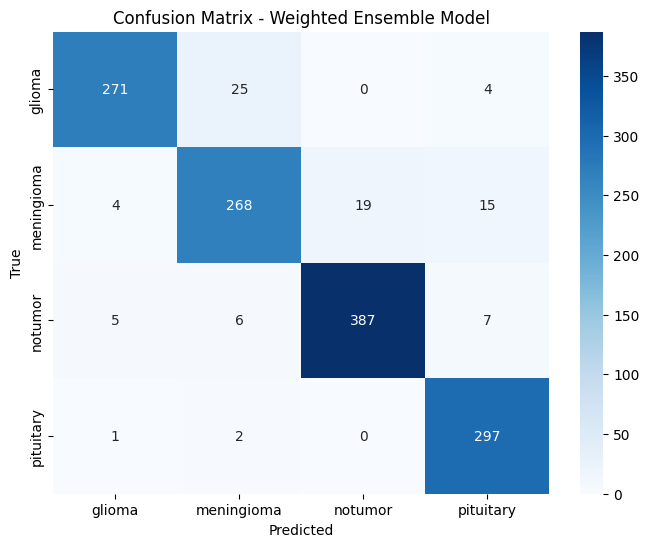

In [103]:
# Classification Report
print("\nClassification Report (Weighted Voting):\n")
print(classification_report(y_true, ensemble_preds, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Weighted Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

                        Model  Accuracy  Precision    Recall  F1-Score
0  Ensemble (Weighted Voting)  0.932876    0.93339  0.932876  0.932592


<Figure size 1000x600 with 0 Axes>

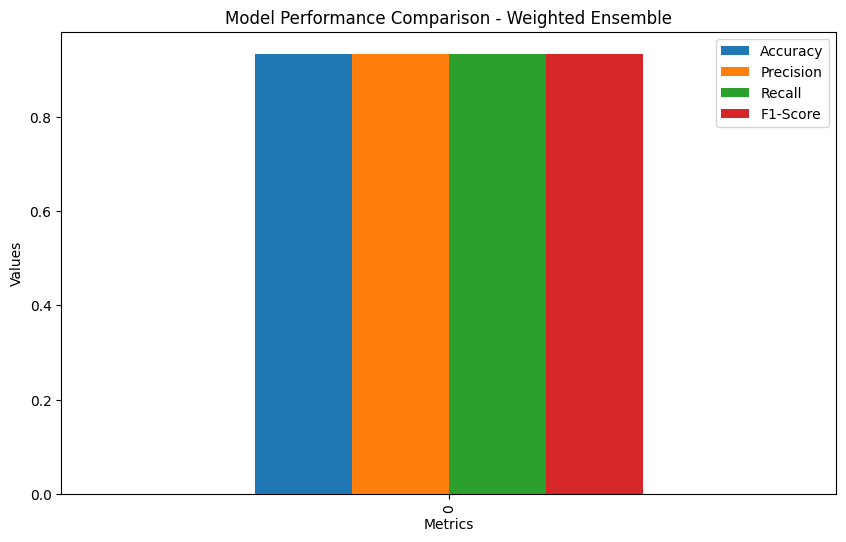

In [105]:
# Store Results for Comparison
results = []
results.append({'Model': 'Ensemble (Weighted Voting)', 'Accuracy': accuracy, 'Precision': precision,
                'Recall': recall, 'F1-Score': f1})

# Convert Results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Visualize the Results
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison - Weighted Ensemble")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend(loc="best")
plt.show()